In [27]:
import os
import json
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [66]:
class BDD100KDataset(Dataset):
    def __init__(self, img_dir, mask_dir, json_file, file_list_txt, transform=None, limit=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

        with open(file_list_txt, 'r') as f:
            self.file_names = [line.strip() for line in f.readlines()]

        if limit:
            self.file_names = self.file_names[:limit]

        with open(json_file) as f:
            self.data = json.load(f)

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = self.file_names[idx]

        img_path = os.path.join(self.img_dir, img_name)
        mask_name = img_name.replace(".jpg", ".png")  # JPG を PNG に変換
        mask_path = os.path.join(self.mask_dir, mask_name)

        if not os.path.exists(img_path) or not os.path.exists(mask_path):
            raise FileNotFoundError(f"File not found: {img_path} or {mask_path}")

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            # マスクの変換は別途行う
            mask = torch.tensor(np.array(mask), dtype=torch.long)

        return image, mask

# 変換の設定
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])


In [67]:
train_dataset = BDD100KDataset(
    "/Volumes/volume/BDD100K/bdd100k/images/100k/train", 
    "/Volumes/volume/BDD100K/bdd100k/labels/ins_seg/bitmasks/train", 
    "/Volumes/volume/BDD100K/bdd100k/labels/ins_seg/rles/ins_seg_train.json",
    "segnet.txt",
    transform=transform, 
    limit=100)
dataloader_train = DataLoader(train_dataset, batch_size=1, shuffle=True)

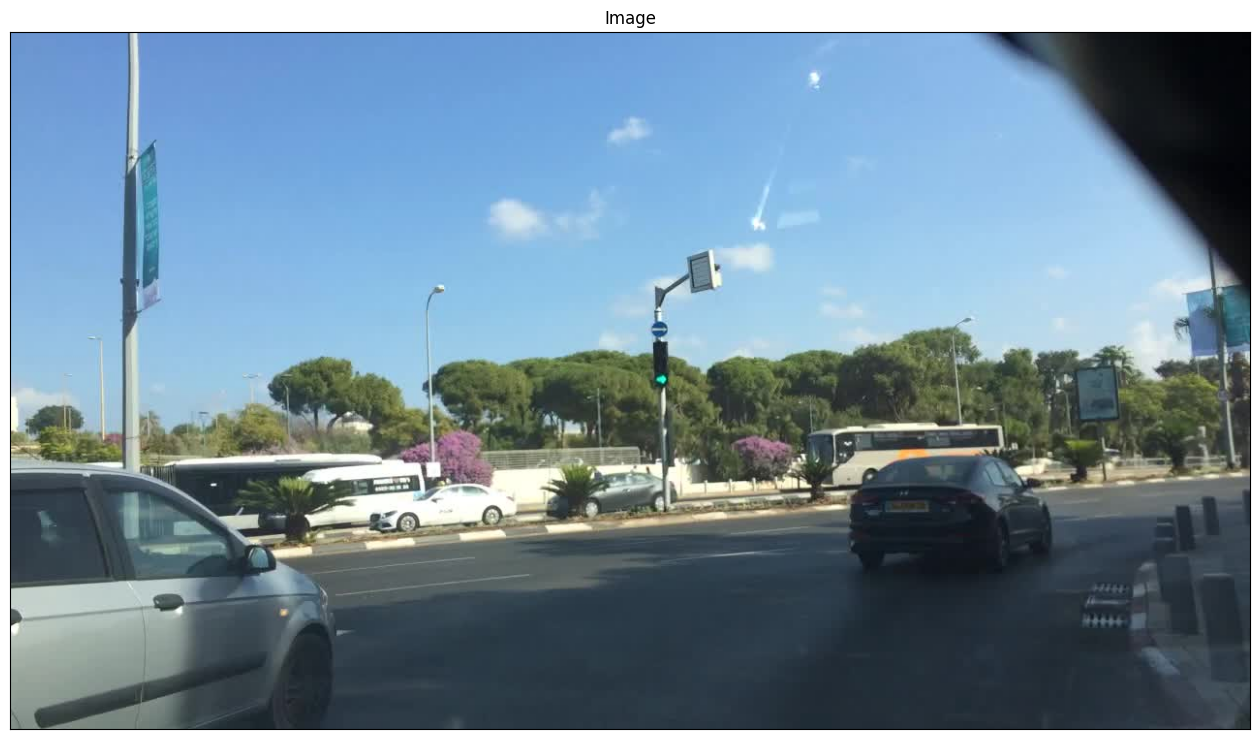

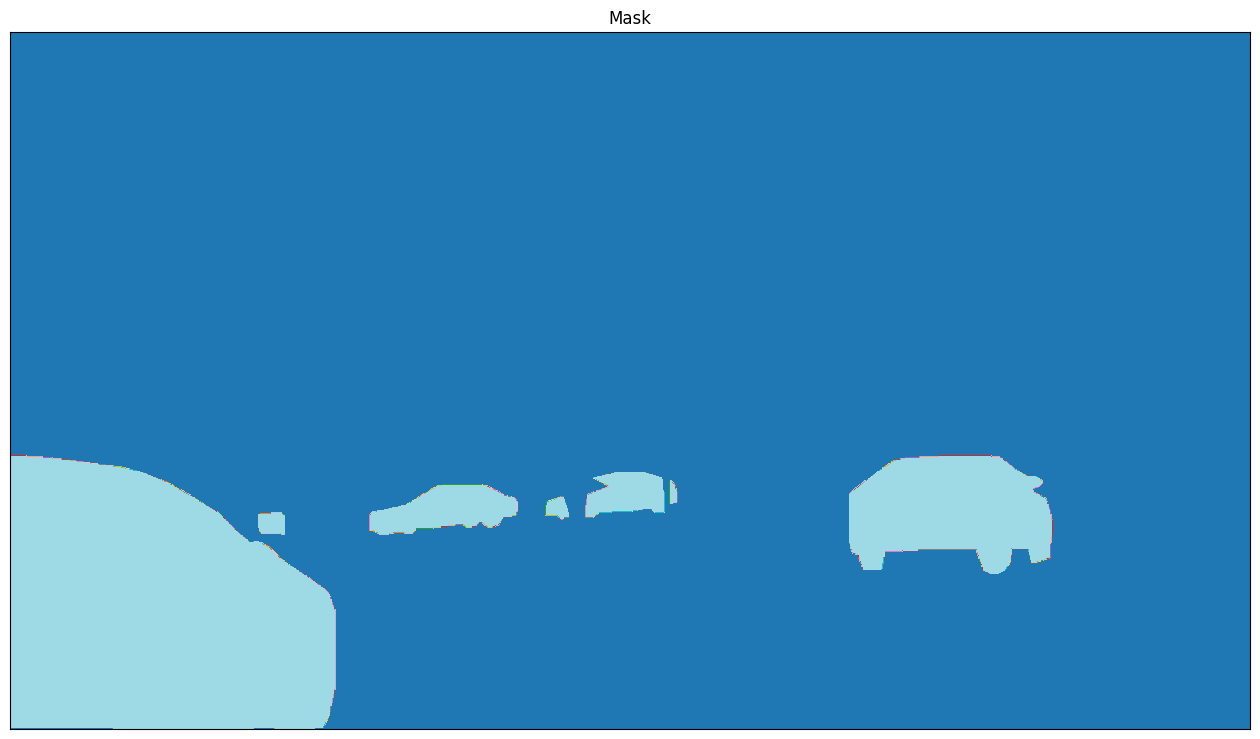

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import torch

dataiter = iter(dataloader_train)  # イテレータ
image, mask = next(dataiter)  # バッチを取り出す

# 画像を表示する
image = image[0]
image = image.permute(1, 2, 0)  # チャンネルを最後に移動
image = image.numpy()  # NumPy 配列に変換
plt.figure(figsize=(16, 16))
plt.imshow(image)  # 画像を表示
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に
plt.title("Image")
plt.show()

# マスクを表示する
mask = mask[0]
mask = mask.squeeze(0)  # バッチ次元を削除
mask = mask.numpy()  # NumPy 配列に変換
plt.figure(figsize=(16, 16))
plt.imshow(mask, cmap='tab20')  # マスクを表示
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
plt.title("Mask")
plt.show()


In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SegNet(nn.Module):
    def __init__(self, num_classes):
        super(SegNet, self).__init__()
        # Encoder
        self.encoder_conv_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.encoder_bn_1 = nn.BatchNorm2d(64)
        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        # Decoder
        self.unpool_1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder_conv_1 = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
        self.decoder_bn_1 = nn.BatchNorm2d(num_classes)
    
    def forward(self, x):
        # Encoder
        x = F.relu(self.encoder_bn_1(self.encoder_conv_1(x)))
        x, indices_1 = self.pool_1(x)
        
        # Decoder
        x = self.unpool_1(x, indices_1)
        x = F.relu(self.decoder_bn_1(self.decoder_conv_1(x)))
        
        return x


In [100]:
import torch
import torch.nn as nn
import torch.optim as optim

model = SegNet(num_classes=20)  # クラス数を設定

# 保存した状態辞書をロード
model.load_state_dict(torch.load('segnet_model.pth'))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for images, masks in dataloader_train:
        # マスクの次元を [batch_size, height, width] に変更し、long型にキャスト
        masks = masks.squeeze(1).long()  # [batch_size, 1, height, width] -> [batch_size, height, width]
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)  # ミニバッチのサイズを考慮
        print(loss.item())
    
    epoch_loss = running_loss / len(dataloader_train.dataset)  # データセット全体の平均損失
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")


0.6980054378509521
0.7199568748474121
0.7518438696861267
0.6882460713386536
1.2635303735733032
0.6226232051849365
1.0581568479537964
1.0594382286071777
0.5871467590332031
0.699424684047699
0.8609980344772339
1.2337000370025635
0.6818872690200806
0.6485820412635803
0.7626180648803711
0.7443217635154724
1.3849118947982788
1.8319554328918457
1.1520835161209106
0.9043006896972656
0.7243039011955261
0.809973418712616
0.988408625125885
0.7023440003395081
0.7364733219146729
1.073043942451477
1.0979540348052979
0.6595472693443298
0.6545506715774536
0.6912805438041687
0.8233646154403687
0.8469374775886536
1.1147006750106812
1.3691710233688354
0.7008545994758606
1.1978471279144287
0.9111770987510681
0.6893553733825684
0.7331598997116089
0.6621654033660889
1.8679887056350708
1.017913818359375
1.0555936098098755
0.9010719060897827
0.6739476323127747
0.7223930954933167
0.6349005103111267
1.163223147392273
0.8761420845985413
1.56436026096344
0.7895843386650085
0.9847707152366638
1.2444583177566528
0

In [101]:
# モデルの状態辞書（state_dict）を保存
torch.save(model.state_dict(), 'segnet_model.pth')


In [105]:
# モデルの定義が必要
model = SegNet(num_classes=20)

# 保存した状態辞書をロード
model.load_state_dict(torch.load('segnet_model.pth'))

# 推論モードに変更（評価時にはこれを使用）
model.eval()

SegNet(
  (encoder_conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool_1): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (decoder_conv_1): Conv2d(64, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_bn_1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])
{0: 921305, 1: 295}


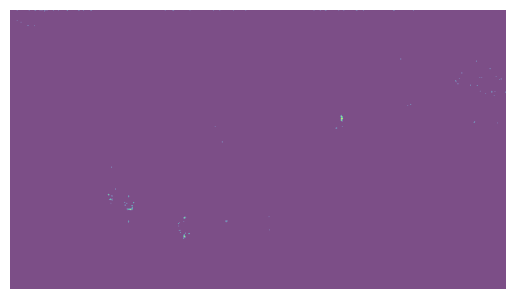

In [110]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# 評価データを準備
img_path = '/Volumes/volume/BDD100K/bdd100k/images/100k/test/cabe1040-5f02711e.jpg'
image = Image.open(img_path).convert('RGB')

# Transform を定義
transform = transforms.Compose([
    transforms.ToTensor()  # ToTensor で自動的に float 型に変換し、[0,1] に正規化
])

# Transform を適用
input_image = transform(image).unsqueeze(0)  # バッチ次元を追加

# 入力データ型を float に変換
input_image = input_image.float()

# 推論の実行（勾配計算を無効化）
with torch.no_grad():
    output = model(input_image)

# 結果の処理
output_predictions = torch.argmax(output, dim=1)  # 予測されたクラスを取得
print(output_predictions)
# 結果を表示
output_predictions = output_predictions.squeeze(0).cpu().numpy()
unique_classes, counts = np.unique(output_predictions, return_counts=True)
print(dict(zip(unique_classes, counts)))

# 20クラス用のカラーマップを作成
cmap = plt.get_cmap('tab20')  # 'tab20' カラーマップを使用

# 出力を表示するために、クラスラベルをカラーマップで色付け
plt.imshow(output_predictions,alpha=0.7)
plt.axis('off')
plt.show()
